In [1]:
import pandas as pd
import numpy as np
import pickle
import torch
import torch.nn as nn
# from transformers import AutoTokenizer, AutoModelForMaskedLM
from enformer_pytorch import Enformer, seq_indices_to_one_hot

import os
import pickle
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

c:\Users\navid\anaconda3\envs\torchgpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load tf enformer embeddings
with open("../embeds/tf_enformer_alternate.pkl", "rb") as f:
    tf_enformer_embeddings = pickle.load(f)

In [4]:
len(tf_enformer_embeddings)

223

In [7]:
len(tf_enformer_embeddings[tf_enformer_embeddings.keys().__iter__().__next__()])

5313

In [19]:
tf_enformer_embeddings[tf_enformer_embeddings.keys().__iter__().__next__()].dtype

torch.float32

In [8]:
df = pd.DataFrame.from_dict(tf_enformer_embeddings, orient='index')

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,5303,5304,5305,5306,5307,5308,5309,5310,5311,5312
AATF,tensor(0.0074),tensor(0.0071),tensor(0.0065),tensor(0.0134),tensor(0.0071),tensor(0.0063),tensor(0.0092),tensor(0.0065),tensor(0.0083),tensor(0.0068),...,tensor(0.0493),tensor(0.0234),tensor(0.0081),tensor(0.0062),tensor(0.0016),tensor(0.0030),tensor(0.0024),tensor(0.0050),tensor(0.0055),tensor(0.0094)
ALX1,tensor(0.0082),tensor(0.0080),tensor(0.0078),tensor(0.0144),tensor(0.0075),tensor(0.0068),tensor(0.0098),tensor(0.0069),tensor(0.0086),tensor(0.0079),...,tensor(0.0503),tensor(0.0303),tensor(0.0089),tensor(0.0064),tensor(0.0012),tensor(0.0038),tensor(0.0028),tensor(0.0052),tensor(0.0082),tensor(0.0082)
ALX4,tensor(0.0084),tensor(0.0080),tensor(0.0077),tensor(0.0134),tensor(0.0076),tensor(0.0068),tensor(0.0095),tensor(0.0070),tensor(0.0085),tensor(0.0076),...,tensor(0.0465),tensor(0.0261),tensor(0.0087),tensor(0.0064),tensor(0.0021),tensor(0.0025),tensor(0.0025),tensor(0.0053),tensor(0.0048),tensor(0.0080)
ARID1A,tensor(0.0086),tensor(0.0083),tensor(0.0078),tensor(0.0145),tensor(0.0080),tensor(0.0071),tensor(0.0104),tensor(0.0076),tensor(0.0090),tensor(0.0078),...,tensor(0.0515),tensor(0.0267),tensor(0.0085),tensor(0.0069),tensor(0.0024),tensor(0.0038),tensor(0.0029),tensor(0.0054),tensor(0.0088),tensor(0.0100)
ARID3A,tensor(0.0074),tensor(0.0071),tensor(0.0063),tensor(0.0119),tensor(0.0067),tensor(0.0058),tensor(0.0085),tensor(0.0063),tensor(0.0074),tensor(0.0068),...,tensor(0.0430),tensor(0.0224),tensor(0.0077),tensor(0.0058),tensor(0.0013),tensor(0.0034),tensor(0.0018),tensor(0.0040),tensor(0.0056),tensor(0.0057)


In [14]:
# Run PCA on embeddings
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def compute_pca(df, variance_threshold=0.95, show_plots=False):
    X = df.values
    print(f"Original embedding shape: {X.shape}")

    # Determine number of components (e.g., keep 95% variance)
    pca_full = PCA(random_state=10701)
    pca_full.fit(X)

    cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
    
    if show_plots:
        # Plot explained variance
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(pca_full.explained_variance_ratio_[:100])
        plt.xlabel('Component')
        plt.ylabel('Explained Variance Ratio')
        plt.title('Explained Variance by Component (first 100)')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(cumulative_variance)
        plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
        plt.axhline(y=0.90, color='g', linestyle='--', label='90% variance')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('Cumulative Explained Variance')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()


    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    print(f"Using {n_components} components for {variance_threshold*100}% variance")

    # Apply PCA transformation
    pca = PCA(n_components=n_components, random_state=10701)
    X_pca = pca.fit_transform(X)

    print(f"\nOriginal embedding shape: {X.shape}")
    print(f"Reduced embedding shape: {X_pca.shape}")
    print(f"Variance explained: {pca.explained_variance_ratio_.sum():.4f}")

    # Create DataFrame with reduced embeddings (keeps TF names as index)
    df_pca = pd.DataFrame(
        X_pca,
        index=df.index,  # Preserve TF names
        columns=[f'PC{i+1}' for i in range(n_components)]
    )

    return df_pca

Original embedding shape: (223, 5313)


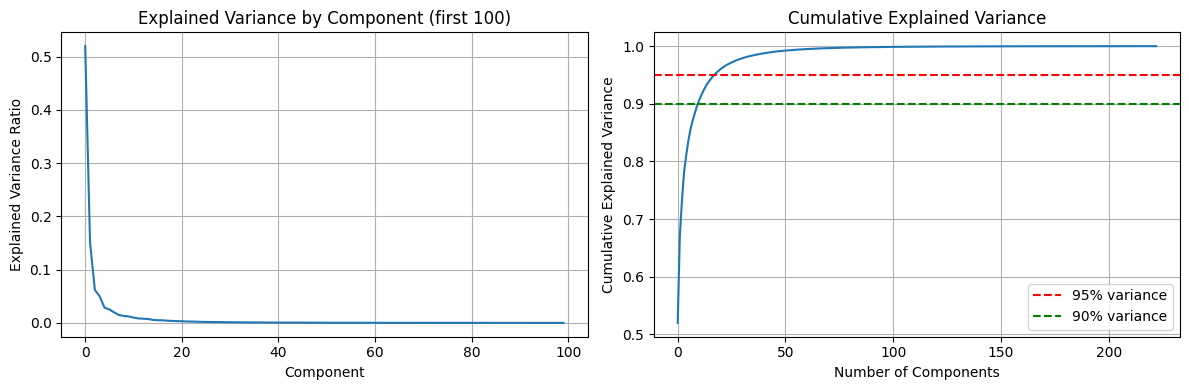

Using 18 components for 95.0% variance

Original embedding shape: (223, 5313)
Reduced embedding shape: (223, 18)
Variance explained: 0.9503


In [15]:
df_pca = compute_pca(df, variance_threshold=0.95, show_plots=True)

In [20]:
# Convert back to dictionary format (like original tf_enformer_embeddings)
tf_enformer_pca_embeddings = {
    tf_name: torch.tensor(df_pca.loc[tf_name].values, dtype=torch.float32)
    for tf_name in df_pca.index
}

In [21]:
tf_enformer_pca_embeddings

{'AATF': tensor([-6.3995e+00,  3.3098e+00, -6.8288e-01, -1.8497e-01,  1.3279e-01,
          7.2884e-02,  3.9402e-01, -1.7358e-03,  1.1977e+00,  1.2468e+00,
         -6.7499e-01, -7.5428e-01,  6.3850e-01, -4.1826e-01, -1.1831e+00,
         -1.8694e-02, -4.8325e-02, -3.6673e-01]),
 'ALX1': tensor([-2.6107, -2.0481,  4.4317,  1.1316,  2.7743, -0.3791, -0.1974,  1.1118,
          0.8218, -0.2801,  4.0025, -0.6168,  0.4230,  0.0791, -0.0213, -0.6765,
         -0.5104,  0.0790]),
 'ALX4': tensor([-2.1731,  0.3823, -4.3358,  0.5652, -0.2061,  1.7918, -1.7983, -1.3541,
          0.7440,  0.7423,  0.5726,  0.1934,  0.7277,  1.1865,  0.8347,  0.4437,
          0.9062, -0.7647]),
 'ARID1A': tensor([ 1.5853,  3.8928, -0.7047,  2.3083, -0.7875,  0.5561, -2.4257, -0.0884,
         -1.7185,  0.5024,  0.1694, -1.1066,  0.9839, -0.0978, -1.1269, -1.7818,
          0.4042, -0.1495]),
 'ARID3A': tensor([ 0.4137,  1.0766,  1.9022,  1.1685, -3.3165, -0.2354, -0.4028, -0.2036,
          0.1703,  0.4002,  0.

In [22]:
with open("../embeds/tf_enformer_alternate_pca.pkl", "wb") as f:
    pickle.dump(tf_enformer_pca_embeddings, f)

In [24]:
# repeat for genes
with open("../embeds/gn_enformer_alternate.pkl", "rb") as f:
    gene_enformer_embeddings = pickle.load(f)

In [25]:
len(gene_enformer_embeddings)

5307

In [30]:
df = pd.DataFrame.from_dict(gene_enformer_embeddings, orient='index')

Original embedding shape: (5307, 5313)


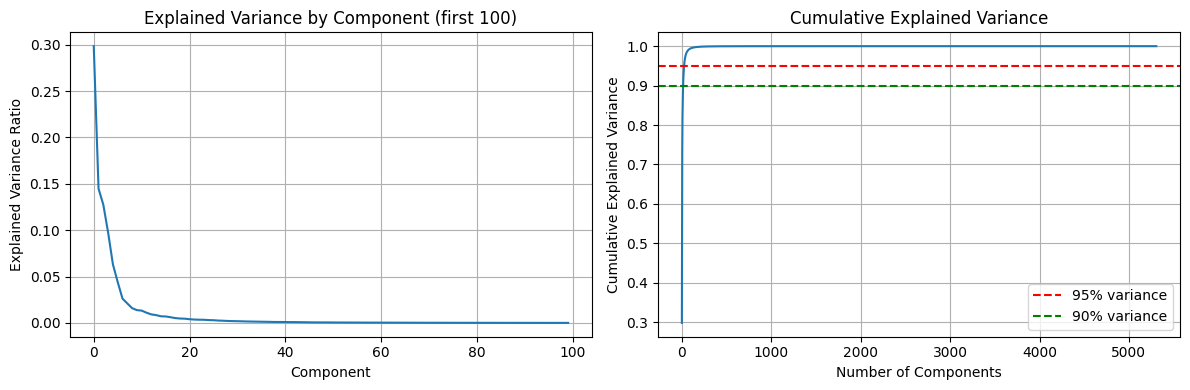

Using 26 components for 95.0% variance

Original embedding shape: (5307, 5313)
Reduced embedding shape: (5307, 26)
Variance explained: 0.9507


In [31]:
df_pca = compute_pca(df, variance_threshold=0.95, show_plots=True)

In [34]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,5303,5304,5305,5306,5307,5308,5309,5310,5311,5312
DPM1,tensor(0.0082),tensor(0.0079),tensor(0.0076),tensor(0.0129),tensor(0.0073),tensor(0.0068),tensor(0.0097),tensor(0.0068),tensor(0.0086),tensor(0.0078),...,tensor(0.0601),tensor(0.0416),tensor(0.0112),tensor(0.0095),tensor(0.0029),tensor(0.0039),tensor(0.0038),tensor(0.0059),tensor(0.0119),tensor(0.0158)
CFH,tensor(0.0078),tensor(0.0075),tensor(0.0067),tensor(0.0123),tensor(0.0073),tensor(0.0065),tensor(0.0094),tensor(0.0067),tensor(0.0084),tensor(0.0070),...,tensor(0.0463),tensor(0.0231),tensor(0.0074),tensor(0.0061),tensor(0.0013),tensor(0.0081),tensor(0.0030),tensor(0.0045),tensor(0.0131),tensor(0.0115)
FUCA2,tensor(0.0085),tensor(0.0078),tensor(0.0078),tensor(0.0146),tensor(0.0076),tensor(0.0069),tensor(0.0095),tensor(0.0065),tensor(0.0085),tensor(0.0076),...,tensor(0.0476),tensor(0.0267),tensor(0.0086),tensor(0.0067),tensor(0.0020),tensor(0.0022),tensor(0.0022),tensor(0.0039),tensor(0.0106),tensor(0.0098)
NIPAL3,tensor(0.0085),tensor(0.0074),tensor(0.0071),tensor(0.0110),tensor(0.0068),tensor(0.0059),tensor(0.0088),tensor(0.0064),tensor(0.0076),tensor(0.0071),...,tensor(0.0476),tensor(0.0281),tensor(0.0089),tensor(0.0079),tensor(0.0040),tensor(0.0034),tensor(0.0029),tensor(0.0042),tensor(0.0051),tensor(0.0088)
LAS1L,tensor(0.0079),tensor(0.0082),tensor(0.0081),tensor(0.0112),tensor(0.0071),tensor(0.0061),tensor(0.0089),tensor(0.0067),tensor(0.0079),tensor(0.0082),...,tensor(0.0430),tensor(0.0280),tensor(0.0082),tensor(0.0059),tensor(0.0020),tensor(0.0011),tensor(0.0019),tensor(0.0039),tensor(0.0039),tensor(0.0041)


In [33]:
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26
DPM1,-4.335566,3.990901,-1.677143,-4.771482,5.766707,2.438723,-0.807935,2.731656,0.325316,0.684416,...,0.196897,-1.390020,0.757954,-0.561410,-0.368223,-0.197373,-0.460660,-0.014515,-0.533780,-0.034463
CFH,1.561888,-5.615042,1.701110,1.372267,4.828830,-1.222488,1.152554,-0.797847,-3.199719,-0.574322,...,1.133680,0.411874,-0.931403,0.092754,0.205220,0.281617,1.549127,0.111884,-1.448308,0.643142
FUCA2,-6.391356,2.243433,1.882496,-5.668380,-1.303251,0.555444,1.048726,-0.643608,2.562834,-0.717168,...,0.311055,0.220969,0.902717,-0.016931,-1.092260,-0.529619,0.439969,-0.241242,-0.408900,-0.098697
NIPAL3,-1.316836,7.511355,-3.434333,1.140731,-1.930669,-0.143184,-0.803078,-1.399146,0.487380,-0.405387,...,-0.215002,-0.543201,-0.408324,-0.436264,0.707290,0.036533,0.412532,-0.646993,0.208693,0.247623
LAS1L,-4.074514,-4.987734,-5.251801,-1.455405,1.187767,2.291005,-0.294878,0.264274,0.603261,1.511965,...,0.707822,-0.023555,0.966396,-0.649748,-0.352156,-0.227091,0.177192,-0.597383,-0.510159,0.147235


In [35]:
df_pca.shape

(5307, 26)

In [36]:
# Convert back to dictionary format (like original tf_enformer_embeddings)
gene_enformer_pca_embeddings = {
    gene_name: torch.tensor(df_pca.loc[gene_name].values, dtype=torch.float32)
    for gene_name in df_pca.index
}

In [37]:
with open("../embeds/gn_enformer_alternate_pca.pkl", "wb") as f:
    pickle.dump(gene_enformer_pca_embeddings, f)

In [38]:
# repeat for nt embeddings now
with open("../embeds/tf_cls.pkl", "rb") as f:
    tf_nt_embeddings = pickle.load(f)

In [39]:
len(tf_nt_embeddings[tf_nt_embeddings.keys().__iter__().__next__()])

1280

In [40]:
df = pd.DataFrame.from_dict(tf_nt_embeddings, orient='index')

In [41]:
df.shape

(223, 1280)

In [42]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
AATF,tensor(0.0476),tensor(0.2459),tensor(0.4629),tensor(0.3186),tensor(-0.7156),tensor(-0.0770),tensor(-0.2253),tensor(0.4414),tensor(-0.0773),tensor(1.3493),...,tensor(0.6356),tensor(0.1261),tensor(-0.1558),tensor(-0.0146),tensor(0.1824),tensor(-0.0081),tensor(-0.6307),tensor(-0.4123),tensor(-0.0157),tensor(0.0697)
ALX1,tensor(0.0576),tensor(0.1100),tensor(0.5832),tensor(0.2034),tensor(-0.7098),tensor(-0.0296),tensor(-0.1919),tensor(0.4628),tensor(0.0059),tensor(1.3467),...,tensor(0.5524),tensor(0.0818),tensor(-0.1049),tensor(-0.0460),tensor(0.0680),tensor(-0.0200),tensor(-0.6857),tensor(-0.4074),tensor(-0.0561),tensor(0.0768)
ALX4,tensor(0.0183),tensor(0.1780),tensor(0.5314),tensor(0.2268),tensor(-0.7204),tensor(-0.0491),tensor(-0.1304),tensor(0.4222),tensor(0.0268),tensor(1.3074),...,tensor(0.4958),tensor(0.0646),tensor(-0.1414),tensor(0.0558),tensor(0.1188),tensor(-0.0249),tensor(-0.7452),tensor(-0.3600),tensor(-0.0280),tensor(0.0559)
ARID1A,tensor(0.0842),tensor(0.1958),tensor(0.4981),tensor(0.2552),tensor(-0.7440),tensor(-0.0768),tensor(-0.1521),tensor(0.4297),tensor(-0.0262),tensor(1.3203),...,tensor(0.5197),tensor(0.0371),tensor(-0.1466),tensor(0.0077),tensor(0.1395),tensor(-0.0045),tensor(-0.7104),tensor(-0.3415),tensor(-0.0057),tensor(0.0028)
ARID3A,tensor(0.0674),tensor(0.2043),tensor(0.4997),tensor(0.2689),tensor(-0.6817),tensor(-0.0247),tensor(-0.2196),tensor(0.4318),tensor(0.0064),tensor(1.2673),...,tensor(0.5026),tensor(0.0716),tensor(-0.1759),tensor(-0.0031),tensor(0.1435),tensor(-0.0212),tensor(-0.6995),tensor(-0.4208),tensor(-0.0058),tensor(0.0378)


Original embedding shape: (223, 1280)


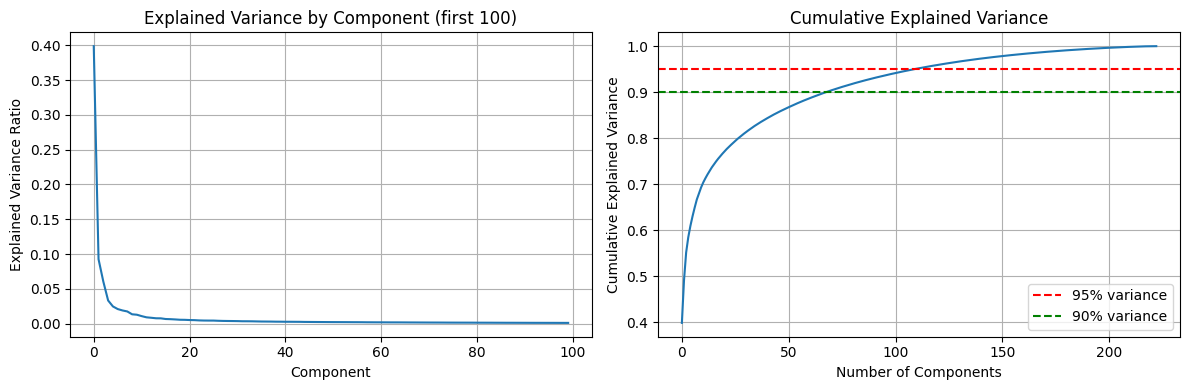

Using 110 components for 95.0% variance

Original embedding shape: (223, 1280)
Reduced embedding shape: (223, 110)
Variance explained: 0.9498


In [43]:
df_pca = compute_pca(df, variance_threshold=0.95, show_plots=True)

In [44]:
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110
AATF,-0.938030,-1.531962,0.141687,-0.202269,0.364323,0.141122,-0.232376,0.024697,-0.079355,0.057449,...,0.001151,0.049792,0.024053,0.047420,-0.015101,-0.009960,0.000391,-0.018625,-0.035694,0.015077
ALX1,0.723489,-0.395825,0.022675,0.389235,-0.227583,0.121956,-0.185678,0.021116,-0.041495,0.046346,...,0.000850,0.012825,0.065580,-0.048977,-0.041933,-0.042527,-0.026350,-0.024867,0.033791,-0.015689
ALX4,-0.370976,0.396801,0.502883,-0.027416,-0.080927,0.106629,-0.101736,0.105145,-0.007452,0.106051,...,0.008193,-0.015395,0.025597,-0.025077,-0.030699,-0.001699,0.009341,0.061958,-0.013009,-0.016357
ARID1A,-0.566168,0.013021,0.422619,0.166183,-0.007943,0.223430,0.113112,0.127372,-0.044935,-0.080022,...,0.009201,0.032305,0.026207,-0.031398,-0.021166,0.085164,-0.014239,0.026158,0.057598,0.037454
ARID3A,-0.779321,-0.034534,-0.065164,-0.230867,0.028365,-0.049149,-0.014239,-0.109722,0.060133,-0.041689,...,0.053263,0.004740,-0.027775,-0.022491,-0.014970,-0.016065,0.047083,0.034634,0.061267,-0.001137


In [45]:
tf_nt_pca_embeddings = {
    tf_name: torch.tensor(df_pca.loc[tf_name].values, dtype=torch.float32)
    for tf_name in df_pca.index
}

In [46]:
tf_nt_pca_embeddings

{'AATF': tensor([-9.3803e-01, -1.5320e+00,  1.4169e-01, -2.0227e-01,  3.6432e-01,
          1.4112e-01, -2.3238e-01,  2.4697e-02, -7.9355e-02,  5.7449e-02,
          4.7881e-02, -1.3458e-01,  1.1604e-02,  8.3882e-02, -1.1315e-01,
         -2.7954e-01, -1.4193e-01,  5.4904e-01,  2.2682e-02, -7.2445e-02,
          2.8391e-01, -1.2268e-01, -7.9072e-02,  1.0826e-01,  6.2809e-02,
         -4.1666e-02,  6.9266e-02,  1.8995e-01, -3.9338e-02,  1.7951e-01,
          1.9518e-02, -2.8070e-01, -1.2052e-01,  1.1476e-01,  3.8686e-03,
         -2.0668e-02, -4.8464e-03, -4.9394e-02,  1.8389e-01, -1.3894e-01,
          3.8195e-02, -2.0611e-02,  1.7791e-02,  6.1227e-02, -1.2245e-01,
         -1.9029e-02,  3.2140e-02,  1.4100e-01,  7.7424e-03, -5.3533e-02,
          1.6785e-01, -5.3025e-02, -1.0481e-01,  2.2021e-02, -1.1738e-01,
          8.4264e-03, -2.1782e-02,  4.2909e-02, -9.4085e-02,  4.1791e-02,
         -2.6401e-02, -8.4986e-02, -5.9672e-03,  1.2712e-01,  3.8765e-02,
          1.2949e-02, -3.9590e

In [ ]:
with open("../embeds/tf_cls_pca.pkl", "wb") as f:
    pickle.dump(tf_nt_pca_embeddings, f)

In [49]:
with open("../embeds/gn_cls.pkl", "rb") as f:
    gene_nt_embeddings = pickle.load(f)

In [50]:
df = pd.DataFrame.from_dict(gene_nt_embeddings, orient='index')

In [51]:
df.shape

(5307, 1280)

In [52]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
DPM1,tensor(0.0661),tensor(0.0603),tensor(0.6031),tensor(0.0839),tensor(-0.8016),tensor(0.0115),tensor(-0.1124),tensor(0.4177),tensor(0.0617),tensor(1.2817),...,tensor(0.5486),tensor(-0.0238),tensor(-0.0954),tensor(0.0052),tensor(0.1254),tensor(0.0029),tensor(-0.7688),tensor(-0.3365),tensor(-0.0683),tensor(0.1175)
CFH,tensor(0.0854),tensor(0.0647),tensor(0.5348),tensor(0.0844),tensor(-0.8134),tensor(-0.0757),tensor(-0.1396),tensor(0.4337),tensor(0.0492),tensor(1.3250),...,tensor(0.5410),tensor(0.0384),tensor(-0.0981),tensor(-0.0142),tensor(0.1273),tensor(0.0215),tensor(-0.7015),tensor(-0.4046),tensor(-0.1106),tensor(0.0826)
FUCA2,tensor(0.1013),tensor(0.0825),tensor(0.4902),tensor(0.1075),tensor(-0.8365),tensor(0.0021),tensor(-0.1019),tensor(0.3820),tensor(0.0021),tensor(1.2897),...,tensor(0.5184),tensor(-0.0262),tensor(-0.1275),tensor(-0.0306),tensor(0.1445),tensor(0.0231),tensor(-0.6888),tensor(-0.4045),tensor(-0.0631),tensor(0.0547)
NIPAL3,tensor(0.0388),tensor(0.1258),tensor(0.5395),tensor(0.1365),tensor(-0.7718),tensor(-0.0104),tensor(-0.1157),tensor(0.4425),tensor(0.0097),tensor(1.2308),...,tensor(0.4900),tensor(-0.0111),tensor(-0.1153),tensor(0.0087),tensor(0.1545),tensor(-0.0219),tensor(-0.7226),tensor(-0.4254),tensor(-0.0709),tensor(0.0938)
LAS1L,tensor(0.0378),tensor(0.1161),tensor(0.5132),tensor(0.1620),tensor(-0.7593),tensor(-0.0197),tensor(-0.0989),tensor(0.4091),tensor(0.0152),tensor(1.2725),...,tensor(0.4995),tensor(-0.0240),tensor(-0.0984),tensor(0.0582),tensor(0.1494),tensor(-0.0257),tensor(-0.7344),tensor(-0.3852),tensor(-0.0576),tensor(0.0981)


Original embedding shape: (5307, 1280)


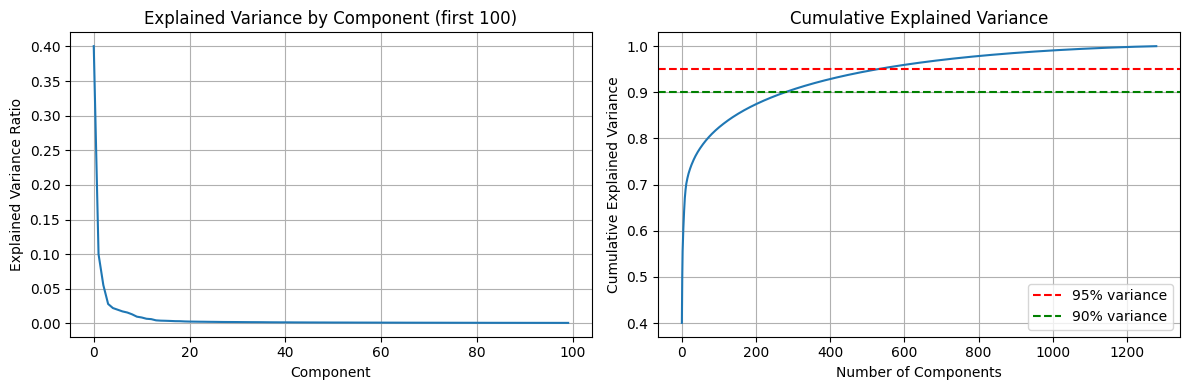

Using 528 components for 95.0% variance

Original embedding shape: (5307, 1280)
Reduced embedding shape: (5307, 528)
Variance explained: 0.9491


In [53]:
df_pca = compute_pca(df, variance_threshold=0.95, show_plots=True)

In [54]:
gene_nt_pca_embeddings = {
    gene_name: torch.tensor(df_pca.loc[gene_name].values, dtype=torch.float32)
    for gene_name in df_pca.index
}

In [55]:
with open("../embeds/gn_cls_pca.pkl", "wb") as f:
    pickle.dump(gene_nt_pca_embeddings, f)